# Дутов Дмитрий
Контакты: 
[Telegram](https://t.me/maunberg)

Почта: maunberg@bk.ru 


# Импорт

In [ ]:
!apt install postgresql postgresql-contrib &>log
!service postgresql start
!sudo -u postgres psql -c "CREATE USER root WITH SUPERUSER"
%load_ext sql
%config SqlMagic.feedback=False
%config SqlMagic.autopandas=True
%sql postgresql+psycopg2://@/postgres

 * Starting PostgreSQL 12 database server
   ...done.
ERROR:  role "root" already exists
The sql extension is already loaded. To reload it, use:
  %reload_ext sql


# Задача 1
В таблице total_sales содержится информация о сделках.


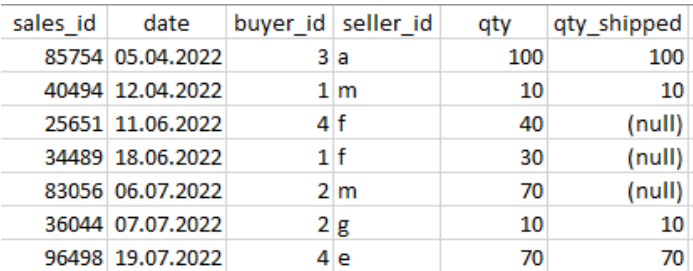

Требуется написать SQL запрос, который к каждой транзакции добавит:
* Дату первой сделки покупателя.
* Дату предыдущей сделки покупателя.
* Покажет общее количество товаров, купленных покупателем.
* Присвоить всем сделкам покупателя / продавца порядковый номер

## Подготовка базы данных

In [ ]:
%sql DROP TABLE total_sales

 * postgresql+psycopg2://@/postgres


""


In [ ]:
%sql  CREATE TABLE total_sales \
      (sales_id INTEGER PRIMARY KEY, \
      date DATE, \
      buyer_id INTEGER, \
      seller_id VARCHAR, \
      qty INTEGER, \
      qty_shipped INTEGER)

 * postgresql+psycopg2://@/postgres


""


In [ ]:
%sql INSERT INTO total_sales(sales_id, date, buyer_id, seller_id, qty, qty_shipped)\
     VALUES (85754, '2022-04-05', 3, 'a', 100, 100), \
     (40494, '2022-04-12', 1, 'm', 10, 10), \
     (25651, '2022-06-11', 4, 'f', 40, Null), \
     (34489, '2022-06-18', 1, 'f', 30, Null), \
     (83059, '2022-07-06', 2, 'm', 70, Null), \
     (36044, '2022-07-07', 2, 'g', 10, 10), \
     (96498, '2022-07-19', 4, 'e', 70, 70) 

 * postgresql+psycopg2://@/postgres


""


# Работа с запросами

In [ ]:
%sql SELECT * FROM total_sales

 * postgresql+psycopg2://@/postgres


,sales_id,date,buyer_id,seller_id,qty,qty_shipped
0,85754,2022-04-05,3,a,100,100.0
1,40494,2022-04-12,1,m,10,10.0
2,25651,2022-06-11,4,f,40,NaN
3,34489,2022-06-18,1,f,30,NaN
4,83059,2022-07-06,2,m,70,NaN
5,36044,2022-07-07,2,g,10,10.0
6,96498,2022-07-19,4,e,70,70.0


In [ ]:
%sql SELECT buyer_id, MIN(date) OVER (PARTITION BY buyer_id) AS first_date\
     FROM total_sales\
     ORDER BY date

 * postgresql+psycopg2://@/postgres


,buyer_id,first_date
0,3,2022-04-05
1,1,2022-04-12
2,4,2022-06-11
3,1,2022-04-12
4,2,2022-07-06
5,2,2022-07-06
6,4,2022-06-11


In [ ]:
%sql SELECT buyer_id, date,\
  LAG(date) OVER (PARTITION BY buyer_id ORDER BY date) AS previous_date\
  FROM total_sales\
  ORDER BY date;

 * postgresql+psycopg2://@/postgres


,buyer_id,date,previous_date
0,3,2022-04-05,None
1,1,2022-04-12,None
2,4,2022-06-11,None
3,1,2022-06-18,2022-04-12
4,2,2022-07-06,None
5,2,2022-07-07,2022-07-06
6,4,2022-07-19,2022-06-11


Будем считать, что qty_shipped - это отправленные товары и они тоже уже куплены 

In [ ]:
%sql SELECT buyer_id,\
  SUM(qty)OVER (PARTITION BY buyer_id) + SUM(qty_shipped) OVER (PARTITION BY buyer_id) AS all_purchases\
  FROM total_sales\
  ORDER BY date;

 * postgresql+psycopg2://@/postgres


,buyer_id,all_purchases
0,3,200
1,1,50
2,4,180
3,1,50
4,2,90
5,2,90
6,4,180


Задание: Присвоить всем сделкам покупателя / продавца порядковый номер

In [ ]:
%sql SELECT buyer_id,\
    ROW_NUMBER() OVER (PARTITION BY buyer_id, seller_id ORDER BY date) AS deal_number\
    FROM total_sales\
    ORDER BY date;

 * postgresql+psycopg2://@/postgres


,buyer_id,deal_number
0,3,1
1,1,1
2,4,1
3,1,1
4,2,1
5,2,1
6,4,1


Мы можем заметить, что у каждой пары продавец/покупатель сделки были произведены впервые, следовательно, задача скорее стоит в том, чтобы для каждого отдельного покупателя и продавца произвести ранжирование сделок.



In [ ]:
%sql SELECT buyer_id,seller_id,\
    ROW_NUMBER() OVER (PARTITION BY buyer_id ORDER BY date) AS buyer_rang,\
    ROW_NUMBER() OVER (PARTITION BY seller_id ORDER BY date) AS seller_rang\
    FROM total_sales\
    ORDER BY date;

 * postgresql+psycopg2://@/postgres


,buyer_id,seller_id,buyer_rang,seller_rang
0,3,a,1,1
1,1,m,1,1
2,4,f,1,1
3,1,f,2,2
4,2,m,1,2
5,2,g,2,1
6,4,e,2,1


## Финальный запрос

Требуется написать SQL запрос, который к каждой транзакции добавит:
* Дату первой сделки покупателя.
* Дату предыдущей сделки покупателя.
* Покажет общее количество товаров, купленных покупателем.
* Присвоить всем сделкам покупателя / продавца порядковый номер

In [ ]:
%sql SELECT *,\
      MIN(date) OVER (PARTITION BY buyer_id) AS first_date,\
      LAG(date) OVER (PARTITION BY buyer_id ORDER BY date) AS previous_date,\
      SUM(qty)OVER (PARTITION BY buyer_id) + SUM(qty_shipped) OVER (PARTITION BY buyer_id) AS all_purchases,\
      ROW_NUMBER() OVER (PARTITION BY buyer_id ORDER BY date) AS buyer_rang,\
      ROW_NUMBER() OVER (PARTITION BY seller_id ORDER BY date) AS seller_rang\
      FROM total_sales\
      ORDER BY date

 * postgresql+psycopg2://@/postgres


,sales_id,date,buyer_id,seller_id,qty,qty_shipped,first_date,previous_date,all_purchases,buyer_rang,seller_rang
0,85754,2022-04-05,3,a,100,100.0,2022-04-05,None,200,1,1
1,40494,2022-04-12,1,m,10,10.0,2022-04-12,None,50,1,1
2,25651,2022-06-11,4,f,40,NaN,2022-06-11,None,180,1,1
3,34489,2022-06-18,1,f,30,NaN,2022-04-12,2022-04-12,50,2,2
4,83059,2022-07-06,2,m,70,NaN,2022-07-06,None,90,1,2
5,36044,2022-07-07,2,g,10,10.0,2022-07-06,2022-07-06,90,2,1
6,96498,2022-07-19,4,e,70,70.0,2022-06-11,2022-06-11,180,2,1


# Задача 2

Схема базы данных:

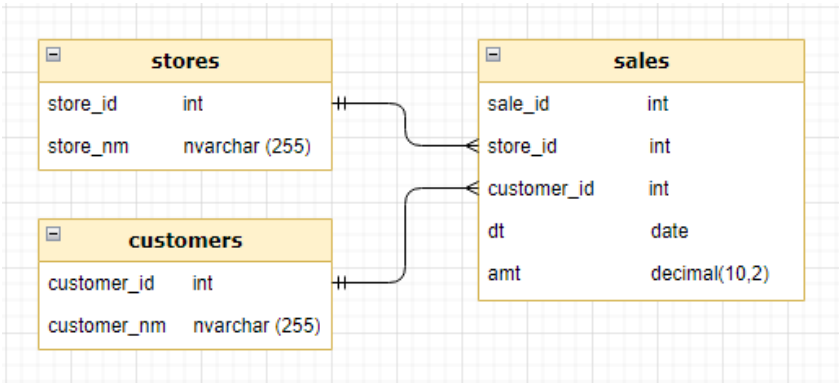

Составьте запросы к базе, отвечающие на вопросы:
* Для каждого покупателя найдите магазин, в котором он совершил
наибольшее количество покупок.
* Найдите всех покупателей, которые в каждом полном месяце этого года
совершали не менее 3 покупок.


Напишите запрос, формирующий ниже представленный отчет.*Курсив*

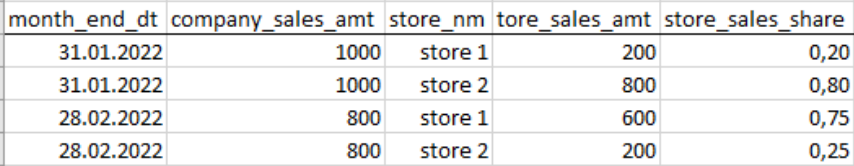

In [ ]:
%sql  CREATE TABLE sales \
      (sale_id INTEGER PRIMARY KEY, \
      store_id INTEGER, \
      customer_id INTEGER, \
      dt DATE, \
      amt DECIMAL(10,2))

 * postgresql+psycopg2://@/postgres


""


In [ ]:
%sql INSERT INTO sales(sale_id, store_id, customer_id, dt, amt)\
      VALUES (1, 1, 1, '2022-01-01', 1),\
      (2, 1, 1, '2022-01-02', 2),\
      (3, 2, 1, '2022-02-01', 5),\
      (4, 2, 1, '2022-03-01', 1),\
      (5, 2, 1, '2022-03-02', 1),\
      (6, 1, 1, '2022-03-03', 1),\
      (7, 3, 1, '2022-04-01', 5),\
      (8, 3, 1, '2022-05-01', 5),\
      (9, 3, 1, '2022-05-02', 5),\
      (10, 3, 1, '2022-06-01', 1),\
      (11, 3, 1, '2022-06-02', 1),\
      (12, 1, 1, '2022-06-03', 1),\
      (13, 2, 1, '2022-07-01', 1),\
      (14, 1, 1, '2022-07-02', 1),\
      (15, 2, 1, '2022-07-03', 4),\
      (16, 1, 1, '2022-08-01', 1),\
      (17, 2, 1, '2022-08-02', 1),\
      (18, 1, 1, '2022-08-03', 2),\
      (19, 2, 1, '2022-09-01', 3),\
      (20, 3, 1, '2022-10-02', 9),\
      (21, 3, 1, '2022-11-01', 3),\
      (24, 3, 1, '2022-12-01', 4),\
      (27, 2, 2, '2022-01-01', 6),\
      (28, 2, 2, '2022-02-02', 63),\
      (29, 2, 2, '2022-02-03', 64),\
      (30, 2, 2, '2022-02-01', 9),\
      (31, 2, 3, '2022-02-01', 12),\
      (32, 2, 5, '2022-01-01', 1),\
      (33, 2, 4, '2022-08-01', 19),\
      (34, 1, 4, '2022-01-01', 31),\
      (35, 3, 3, '2022-01-01', 18),\
      (36, 1, 3, '2022-06-01', 26),\
      (37, 3, 3, '2022-01-01', 58),\
      (38, 3, 2, '2022-07-01', 9),\
      (39, 3, 2, '2022-01-01', 79),\
      (40, 1, 4, '2022-01-01', 33)

 * postgresql+psycopg2://@/postgres


""


## 1.a
Для каждого покупателя найдите магазин, в котором он совершил
наибольшее количество покупок.

In [ ]:
%sql WITH sub AS (SELECT customer_id, store_id, SUM(amt) AS sum_smt\
          FROM sales\
          GROUP BY customer_id, store_id)\
      SELECT sub.customer_id, store_id\
      FROM sub\
      RIGHT JOIN (\
            SELECT customer_id, MAX(sum_smt)\
            FROM sub\
            GROUP BY customer_id) \
          AS sub_2 ON sub.customer_id=sub_2.customer_id AND sub.sum_smt=sub_2.max\
      ORDER BY sub.customer_id

 * postgresql+psycopg2://@/postgres


,customer_id,store_id
0,1,3
1,2,2
2,3,3
3,4,1
4,5,2


## 1.b 
Найдите всех покупателей, которые в каждом полном месяце этого года
совершали не менее 3 покупок

In [ ]:
%sql WITH sub AS (SELECT customer_id, EXTRACT(MONTH FROM dt) AS month\
      FROM sales\
      GROUP BY customer_id, EXTRACT(MONTH FROM dt)\
      HAVING SUM(amt)>=3\
      ORDER BY customer_id, month)\
      SELECT customer_id\
      FROM sub\
      GROUP BY customer_id\
      HAVING COUNT(month)=12


 * postgresql+psycopg2://@/postgres


,customer_id
0,1


## 2. 
Напишите запрос, формирующий ниже представленный отчет

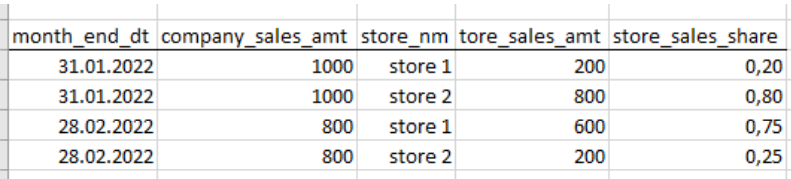

Если не учитывать, что для вышеописанной таблицы нужно соединить таблицы sales и stores, то запрос будет выглядеть так:

In [ ]:
%sql WITH sub AS (SELECT DATE(date_trunc('month', dt) + INTERVAL '1 month - 1 day') as last_day_of_month,\
      SUM(amt) OVER (PARTITION BY DATE(date_trunc('month', dt) + INTERVAL '1 month - 1 day')) AS company_sales_amt, store_id, \
      SUM(amt) OVER (PARTITION BY DATE(date_trunc('month', dt) + INTERVAL '1 month - 1 day'), store_id) AS store_sales_amt\
      FROM sales\
      GROUP BY last_day_of_month, amt, store_id\
      ORDER BY last_day_of_month)\
      SELECT DISTINCT*, ROUND(store_sales_amt/company_sales_amt, 2) AS store_sales_share\
      FROM sub\
      ORDER BY last_day_of_month, store_id


 * postgresql+psycopg2://@/postgres


,last_day_of_month,company_sales_amt,store_id,store_sales_amt,store_sales_share
0,2022-01-31,229.00,1,67.00,0.29
1,2022-01-31,229.00,2,7.00,0.03
2,2022-01-31,229.00,3,155.00,0.68
3,2022-02-28,153.00,2,153.00,1.00
4,2022-03-31,2.00,1,1.00,0.50
5,2022-03-31,2.00,2,1.00,0.50
6,2022-04-30,5.00,3,5.00,1.00
7,2022-05-31,5.00,3,5.00,1.00
8,2022-06-30,28.00,1,27.00,0.96
9,2022-06-30,28.00,3,1.00,0.04


# Задача 3

## Запрос 1
В таблице calls хранятся данные всех звонков абонентов за отчетный месяц. В
поле roaming указан факт нахождения абонента в роуминге во время звонка:
* 1 - абонент был в роуминге;
* 0 - абонент не был в роуминге.

НапишитеSQL запрос, определяющий уникальные id абонентов, которые хоть раз
звонили в роуминге за отчетный месяц.

In [ ]:
%sql DROP TABLE calls

 * postgresql+psycopg2://@/postgres


""


In [ ]:
%sql  CREATE TABLE calls \
      (id_calls INTEGER PRIMARY KEY, \
       id_abon INTEGER, \
       date DATE,\
       time TIME,\
       roaming BOOLEAN)

 * postgresql+psycopg2://@/postgres


""


In [ ]:
%sql INSERT INTO calls(id_calls, id_abon, date, time, roaming)\
     VALUES (854, 1, '2017-01-01', '13:01', True), \
     (654, 1, '2017-01-17', '15:01', False), \
     (978, 2, '2017-01-11', '9:01', False)

 * postgresql+psycopg2://@/postgres


""


In [ ]:
%sql SELECT * FROM calls

 * postgresql+psycopg2://@/postgres


,id_calls,id_abon,date,time,roaming
0,854,1,2017-01-01,13:01:00,True
1,654,1,2017-01-17,15:01:00,False
2,978,2,2017-01-11,09:01:00,False


In [ ]:
%sql SELECT DISTINCT id_abon\
      FROM calls\
      WHERE roaming=True

 * postgresql+psycopg2://@/postgres


,id_abon
0,1


Добавим ещё одну строку, чтобы проверить, действительно ли выводится уникальный ID

In [ ]:
%sql INSERT INTO calls(id_calls, id_abon, date, time, roaming)\
     VALUES (554, 1, '2017-01-05', '1:01', True)

 * postgresql+psycopg2://@/postgres


""


In [ ]:
%sql SELECT DISTINCT id_abon\
      FROM calls\
      WHERE roaming=True

 * postgresql+psycopg2://@/postgres


,id_abon
0,1


## Запрос 2

В таблице abnt хранятся уникальные id всех абонентов, совершавших звонки за
отчетный месяц. В таблице roam хранятся уникальные id абонентов, которые
были в роуминге за отчетный месяц.
Напишите SQL запрос, результатом которого будут все id абонентов, которые не
были в роуминге в текущем месяце.

### Работа с базой данных

In [ ]:
%sql DROP TABLE roam

 * postgresql+psycopg2://@/postgres


""


In [ ]:
%sql  CREATE TABLE abnt \
      (id_abon INTEGER PRIMARY KEY,\
       clc INTEGER)

 * postgresql+psycopg2://@/postgres


""


In [ ]:
%sql INSERT INTO abnt(id_abon, clc)\
      VALUES (1, 800),\
      (2, 350),\
      (3, 700),\
      (4, 0),\
      (5, 0)

 * postgresql+psycopg2://@/postgres


""


In [ ]:
%sql  CREATE TABLE roam \
      (id_abon INTEGER PRIMARY KEY,\
       clc INTEGER)

 * postgresql+psycopg2://@/postgres


""


In [ ]:
%sql INSERT INTO roam(id_abon, clc)\
      VALUES (1, 800),\
      (3, 550),\
      (5, 0)

 * postgresql+psycopg2://@/postgres


""


### Запрос

In [ ]:
%sql SELECT id_abon\
    FROM abnt\
    WHERE abnt.id_abon NOT IN (SELECT id_abon FROM roam)

 * postgresql+psycopg2://@/postgres


,id_abon
0,2
1,4


## Запрос 3

Напишите SQL запрос, который выведет всех абонентов с начислениями в
домашней сети больше 0.


In [ ]:
%sql SELECT abnt.id_abon\
    FROM abnt\
    JOIN roam ON abnt.id_abon = roam.id_abon\
    WHERE (abnt.clc-roam.clc)>0


 * postgresql+psycopg2://@/postgres


,id_abon
0,3


## Запрос 4

Используя данные таблицы calls, выведите id всех абонентов, у которых было
больше 5 звонков в роуминге.

In [ ]:
%sql SELECT * FROM calls

 * postgresql+psycopg2://@/postgres


,id_calls,id_abon,date,time,roaming
0,854,1,2017-01-01,13:01:00,True
1,654,1,2017-01-17,15:01:00,False
2,978,2,2017-01-11,09:01:00,False
3,554,1,2017-01-05,01:01:00,True


In [ ]:
%sql INSERT INTO calls(id_calls, id_abon, date, time, roaming)\
     VALUES (589, 1, '2017-01-01', '11:01', True), \
     (216, 1, '2017-01-17', '10:01', True), \
     (247, 1, '2017-01-19', '9:01', True), \
     (256, 2, '2017-01-16', '15:01', True), \
     (257, 2, '2017-01-01', '19:01', False), \
     (206, 3, '2017-01-7', '5:01', False), \
     (207, 3, '2017-01-21', '4:01', True), \
     (581, 1, '2017-01-02', '11:58', True)

 * postgresql+psycopg2://@/postgres


""


In [ ]:
%sql SELECT * FROM calls ORDER BY date

 * postgresql+psycopg2://@/postgres


,id_calls,id_abon,date,time,roaming
0,589,1,2017-01-01,11:01:00,True
1,854,1,2017-01-01,13:01:00,True
2,257,2,2017-01-01,19:01:00,False
3,581,1,2017-01-02,11:58:00,True
4,554,1,2017-01-05,01:01:00,True
5,206,3,2017-01-07,05:01:00,False
6,978,2,2017-01-11,09:01:00,False
7,256,2,2017-01-16,15:01:00,True
8,216,1,2017-01-17,10:01:00,True
9,654,1,2017-01-17,15:01:00,False


### Запрос

In [ ]:
%sql SELECT DISTINCT id_abon\
    FROM calls\
    WHERE id_abon IN ( SELECT id_abon\
                      FROM calls\
                      WHERE roaming = True\
                      GROUP BY id_abon\
                      HAVING COUNT(roaming)>5\
                      )

 * postgresql+psycopg2://@/postgres


,id_abon
0,1


## Запрос 5

Используя данные таблицы calls, выведите периоды нахождения абонентов в
роуминге. Время пребывания в роуминге определяется непрерывной последовательностью звонков в роуминге.


In [ ]:
%sql SELECT id_abon, MIN(date) as start_date, MAX(date) as end_date\
FROM (\
  SELECT id_abon, date, roaming,\
         SUM(start_of_sequence) OVER (PARTITION BY id_abon ORDER BY date) as group_id\
  FROM (\
    SELECT id_abon, date, roaming,\
           CASE WHEN roaming = LAG(roaming, 1) OVER (PARTITION BY id_abon ORDER BY date)\
                THEN 0\
                ELSE 1\
           END as start_of_sequence\
    FROM calls\
  ) as subquery\
) as subquery2\
WHERE roaming = true\
GROUP BY id_abon, group_id

 * postgresql+psycopg2://@/postgres


,id_abon,start_date,end_date
0,1,2017-01-01,2017-01-05
1,1,2017-01-19,2017-01-19
2,2,2017-01-16,2017-01-16
3,3,2017-01-21,2017-01-21
4,1,2017-01-17,2017-01-17


# Задача 4

У вас есть две таблицы:
* t1 - данные по заявкам на Подбор кредита с сайта Сравни.ру;
* t2 - выгрузка банка о решениях по выдаче кредита.

Напишите SQL-запрос, содержащий всех пользователей, получивших кредит

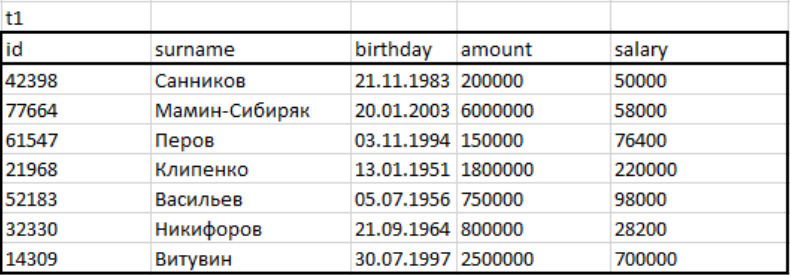

In [ ]:
%sql  CREATE TABLE t1 \
      (id INTEGER PRIMARY KEY,\
       surname VARCHAR,\
       birthday DATE,\
       amount INTEGER,\
       salary INTEGER)

 * postgresql+psycopg2://@/postgres


""


In [ ]:
%sql INSERT INTO t1(id, surname, birthday, amount, salary)\
      VALUES (42398, 'Санников', '1983-11-21', 200000, 50000),\
      (77664, 'Мамин-Сибиряк', '2003-01-20', 6000000, 58000),\
      (61547, 'Перов', '1994-11-03', 150000, 76400),\
      (21968, 'Клипенко', '1951-01-13', 1800000, 220000),\
      (52183, 'Васильев', '1956-05-07', 750000, 98000),\
      (32330, 'Никифоров', '1964-09-21', 800000, 28200),\
      (14309, 'Витувин', '1997-07-30', 2500000, 700000)

 * postgresql+psycopg2://@/postgres


""


In [ ]:
%sql SELECT * FROM t1

 * postgresql+psycopg2://@/postgres


,id,surname,birthday,amount,salary
0,42398,Санников,1983-11-21,200000,50000
1,77664,Мамин-Сибиряк,2003-01-20,6000000,58000
2,61547,Перов,1994-11-03,150000,76400
3,21968,Клипенко,1951-01-13,1800000,220000
4,52183,Васильев,1956-05-07,750000,98000
5,32330,Никифоров,1964-09-21,800000,28200
6,14309,Витувин,1997-07-30,2500000,700000


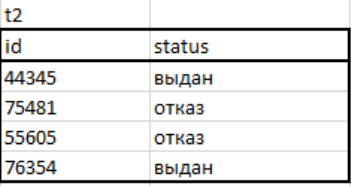

In [ ]:
%sql  CREATE TABLE t2 \
      (id INTEGER PRIMARY KEY,\
       status VARCHAR)

 * postgresql+psycopg2://@/postgres


""


In [ ]:
%sql INSERT INTO t2(id, status)\
    VALUES (42398, 'выдан'),\
    (77664, 'отказ'),\
    (61547, 'отказ'),\
    (21968, 'выдан'),\
    (52183, 'отказ'),\
    (32330, 'отказ'),\
    (14309, 'выдан')

 * postgresql+psycopg2://@/postgres


""


In [ ]:
%sql SELECT * FROM t2

 * postgresql+psycopg2://@/postgres


,id,status
0,42398,выдан
1,77664,отказ
2,61547,отказ
3,21968,выдан
4,52183,отказ
5,32330,отказ
6,14309,выдан


## Запрос

In [ ]:
%sql SELECT *\
    FROM t1\
    JOIN t2 ON t1.id=t2.id\
    WHERE status='выдан'

 * postgresql+psycopg2://@/postgres


,id,surname,birthday,amount,salary,id,status
0,42398,Санников,1983-11-21,200000,50000,42398,выдан
1,21968,Клипенко,1951-01-13,1800000,220000,21968,выдан
2,14309,Витувин,1997-07-30,2500000,700000,14309,выдан
